Imagine we have a tile of locations, say "cortical columns" that tile the visual field. 

Each column represents a patch of the full visual space. And each patch encodes the visual features with the same set of sparse filters and code words.



In [610]:
from __future__ import division

import scipy
import time
import utils
import hrr_utils
import sklearn
import sklearn.metrics as metrics
import numpy as np
import imnet_utils as imut

from pylab import *
from sklearn.decomposition import PCA, FastICA, TruncatedSVD, NMF
from sklearn.datasets import load_digits
from sklearn.feature_extraction import image
from mnist import MNIST
import matplotlib.pyplot as plt 

%matplotlib inline

plt.rcParams.update({'axes.titlesize': 'xx-large'})
plt.rcParams.update({'axes.labelsize': 'xx-large'})
plt.rcParams.update({'xtick.labelsize': 'x-large', 'ytick.labelsize': 'x-large'})
plt.rcParams.update({'legend.fontsize': 'x-large'})
plt.rcParams.update({'text.usetex': True})


In [245]:
NUM_CLASSES = 10

def load_dataset():
    mndata = MNIST('data/mnist/')
    X_train, labels_train = map(np.array, mndata.load_training())
    X_test, labels_test = map(np.array, mndata.load_testing())
    X_train = X_train/255.0
    X_test = X_test/255.0
    X_train = np.resize(X_train, (X_train.shape[0], 28, 28))
    X_test = np.resize(X_test, (X_test.shape[0], 28, 28))
    return (X_train, labels_train), (X_test, labels_test)

def load_patches(imgs, num_imgs, labels, patch_size=(5,5)):
    im_patches = np.zeros((patch_size[0], patch_size[1], num_imgs))
#     indices = np.random.choice(imgs.shape[0], num_imgs, replace=False)
    indices = np.random.choice(imgs.shape[0], num_imgs, replace=True)
    new_labels = []
    for i in range(num_imgs):
        new_labels.append(labels[indices[i]])
        im = imgs[indices[i]]
        randr_st = np.random.randint(im.shape[0] - patch_size[0]-1)
        randc_st = np.random.randint(im.shape[1] - patch_size[1]-1)
        im_patches[:,:,i] = im[randr_st:(randr_st + patch_size[0]), 
                                    randc_st:(randc_st + patch_size[1])]
    return im_patches+1, np.array(new_labels)
    
def load_random_patches(train, test, train_labels, test_labels, num_imgs=10, patch_size=(5,5)):
    train_patches, train_is = load_patches(train, int(num_imgs*.8), train_labels, patch_size)
    test_patches, test_is = load_patches(test, int(num_imgs*.2), test_labels, patch_size)
    return train_patches, test_patches, train_is, test_is

def clip(img):
    cimg = img.copy()
    cimg[cimg > 1] = 1
    cimg[cimg < 1] = -1
    return cimg

def norm_range(v):
    return (v-v.min())/(v.max()-v.min())

In [246]:
(X_train, labels_train), (X_test, labels_test) = load_dataset()

In [247]:
print X_train.shape

(60000, 28, 28)


In [350]:
reload(imut)
patch_size=(5,5)
num_imgs=100000
tstart = time.time()

train_impatches, test_impatches, _, _ = load_random_patches(X_train, X_test, labels_train, labels_test, num_imgs, patch_size=patch_size)

# take a random number, then take a random patch in the number, then do that 100k times

print "Duration: ", time.time() - tstart


Duration:  0.60910987854


In [351]:
# for i in range(test_impatches.shape[2]):
#     plt.figure()
#     plt.imshow((test_impatches[:,:,i]-1)/255)
#     plt.show()

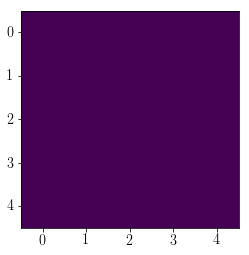

In [352]:
tims = train_impatches-1

imshow(tims[:,:,0])


(25, 80000)


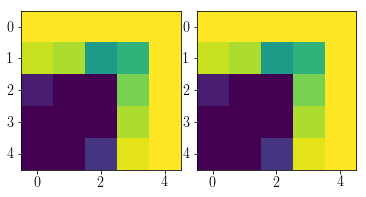

In [353]:
impatchr = train_impatches.copy().reshape((-1, train_impatches.shape[2]))
print impatchr.shape
impatchr -= 1
#impatchr /= 255

im_show = 16

irec = impatchr[:,im_show].reshape((train_impatches.shape[0], train_impatches.shape[1]))

subplot(121)
imshow((train_impatches[:,:,im_show]-1))
subplot(122)
imshow(irec)

In [354]:
mean01 = impatchr.mean()
impatchr -= mean01


In [355]:
ncomponents = min(25, patch_size[0]*patch_size[1])

#pca_encoder = TruncatedSVD(ncomponents)
pca_encoder = PCA(ncomponents)
fica_encoder = FastICA(ncomponents)

In [356]:
tstart = time.time()
pca_encoder.fit(impatchr.T)
print 'Duration: ', time.time() - tstart

Duration:  0.132597923279


In [357]:
scores = pca_encoder.transform(impatchr.T)

In [358]:
pc_comp = pca_encoder.components_

print pc_comp.shape

pc_comp_ims = pc_comp.T.reshape((train_impatches.shape[0], train_impatches.shape[1], -1))



(25, 25)


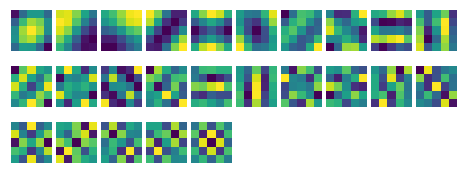

In [359]:
plt.rcParams['figure.subplot.hspace'] = 0.1
plt.rcParams['figure.subplot.wspace'] = 0.1

figure(figsize=(8,3))

nshow = 25
maxrow = 10
for i in range(nshow):
    ax=subplot(nshow//(maxrow-1)+1,maxrow,i+1)
    imshow(norm_range(pc_comp_ims[:,:,i]))
    ax.set_xticks([])
    ax.set_yticks([])
    ax.set_frame_on(False)


In [360]:
tstart = time.time()
which_pcs = arange(20) #np.arange(scores.shape[1])
fica_encoder.fit(scores[:,which_pcs])
print 'Duration: ', time.time() - tstart


Duration:  3.06976985931


In [361]:
ic_scores = fica_encoder.transform(scores[:,which_pcs])

In [362]:
pc_scores = scores[:ic_scores.shape[0], :ic_scores.shape[1]]


In [363]:
ic_comp = fica_encoder.components_
ic_comp /= ic_comp.std(axis=0)
ic_comp = np.dot(ic_comp, pc_comp[which_pcs,:])
print ic_comp.shape

(20, 25)


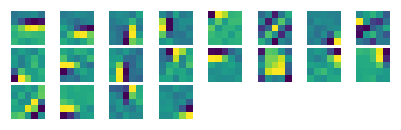

In [364]:
ic_comp_ims = ic_comp.T.reshape((train_impatches.shape[0], train_impatches.shape[1], -1))
figure(figsize=(7,2))
nshow = len(which_pcs) #min(len(which_pcs), 240)
maxrow = 8
for i in range(nshow):
    ax=subplot(nshow//maxrow+1,maxrow,i+1)
    imshow(norm_range(ic_comp_ims[:,:,i+0]))
    ax.set_xticks([])
    ax.set_yticks([])
    ax.set_frame_on(False)

In [365]:
reload(imut)
nrecon = 16
ic_c = linalg.lstsq(ic_comp.T, impatchr)
pc_c = linalg.lstsq(pc_comp[which_pcs,:].T, impatchr)
ic_code = ic_c[0].T
pc_code = pc_c[0].T

In [366]:
print (ic_comp.shape, impatchr.shape, ic_code.shape, pc_code.shape)

((20, 25), (25, 80000), (80000, 20), (80000, 20))


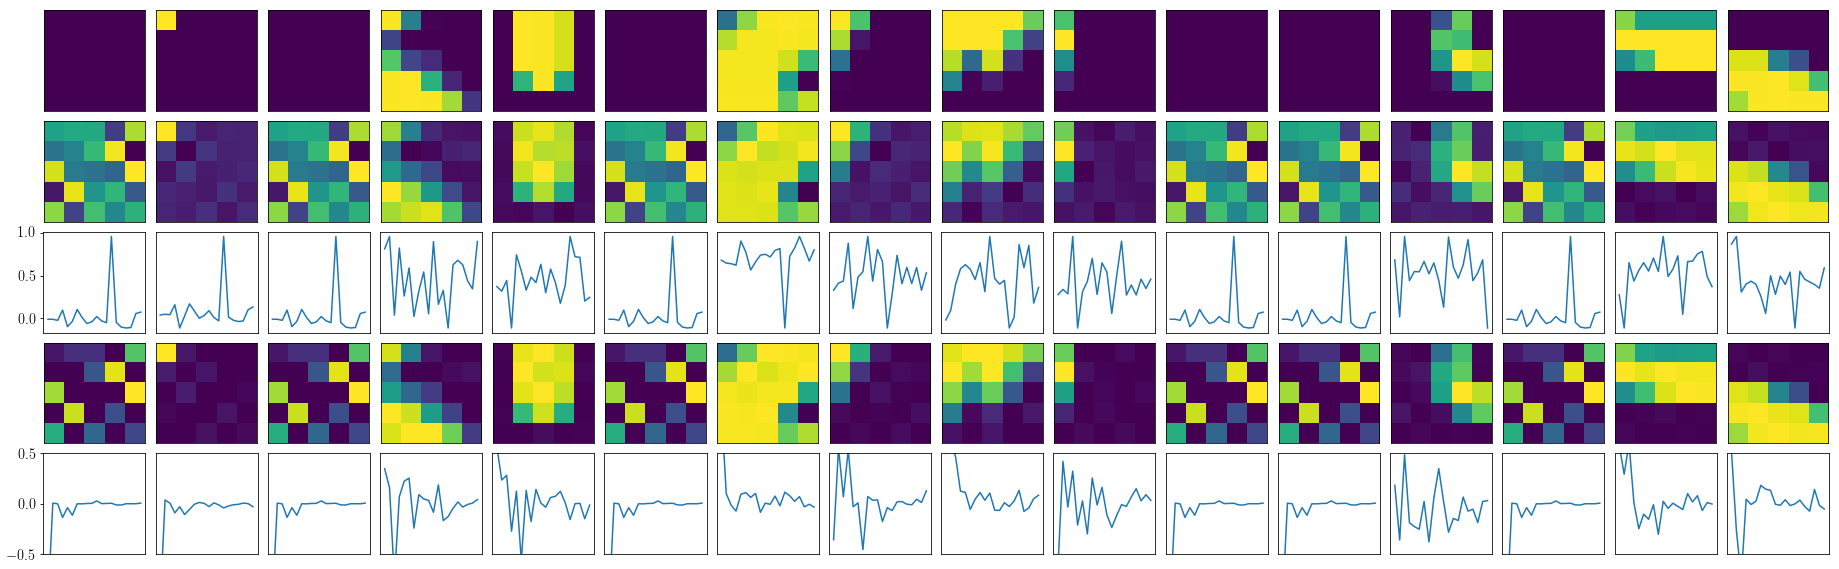

In [370]:


figure(figsize=(32, 10))

for imx in range(nrecon):
    
    ax = subplot(5, nrecon, imx + 1)
    imp = impatchr[:,imx].reshape(patch_size[0], patch_size[1])
    imshow(imp)
    ax.set_xticks([])
    ax.set_yticks([])
    
    ax = subplot(5, nrecon, imx + 1 + nrecon)
    ic_recon = np.dot(ic_code[imx,:], ic_comp) 
    ic_reconr = ic_recon.reshape(patch_size[0], patch_size[1])
    ic_reconr += mean01
    #ic_reconr[ic_reconr<0] = 0
    #ic_reconr[ic_reconr>1] = 1
    imshow(ic_reconr)
    ax.set_xticks([])
    ax.set_yticks([])
    
    
    ax = subplot(5, nrecon, imx + 1 + 2*nrecon)
    plot(ic_code[imx,:].T/norm(ic_code[imx, :]))
    ax.set_xticks([])
    #ax.set_ylim([-0.5, 0.5])
    if imx > 0:
        ax.set_yticks([])

    ax = subplot(5, nrecon, imx + 1 + 3*nrecon)
    pc_recon = np.dot(pc_code[imx,:], pc_comp[which_pcs,:])
    pc_reconr = pc_recon.reshape(patch_size[0], patch_size[1])
    pc_reconr += mean01
    pc_reconr[pc_reconr<0] = 0
    pc_reconr[pc_reconr>1] = 1
    
    imshow(norm_range(pc_reconr))
    ax.set_xticks([])
    ax.set_yticks([])
    
    ax = subplot(5, nrecon, imx + 1 + 4*nrecon)
    plot(pc_code[imx,:].T/norm(pc_code[imx, :]))
    ax.set_xticks([])
    ax.set_ylim([-0.5, 0.5])
    if imx > 0:
        ax.set_yticks([])


In [372]:
ic_reconr.min()

-0.032856418347450844

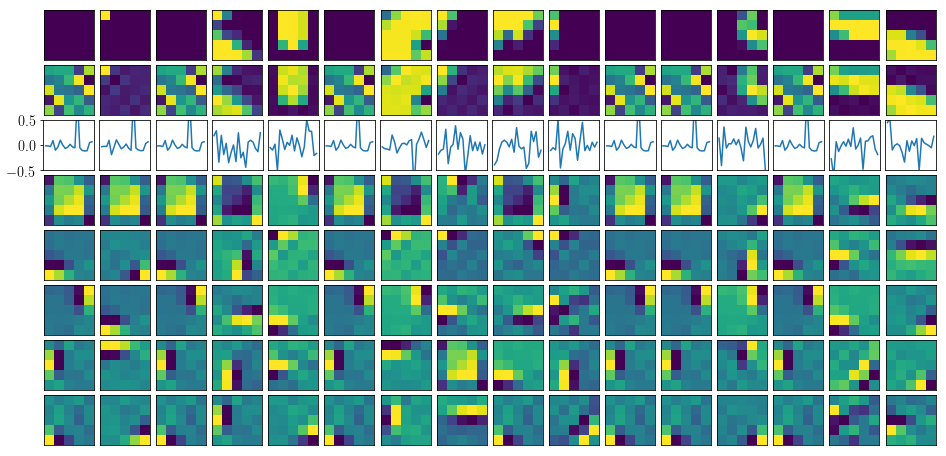

In [369]:
figure(figsize=(16, 8))

ic_ex = 2*arange(5)+1
nrows = 3 + len(ic_ex)
for imx in range(nrecon):
    
    ax = subplot(nrows, nrecon, imx + 1)
    imp = impatchr[:,imx].reshape(patch_size[0], patch_size[1])
    imshow(imp)
    ax.set_xticks([])
    ax.set_yticks([])
    
    ax = subplot(nrows, nrecon, imx + 1 + nrecon)
    ic_recon = np.dot(ic_code[imx,:], ic_comp)
    ic_reconr = ic_recon.reshape(patch_size[0], patch_size[1])
    imshow(norm_range(ic_reconr))
    ax.set_xticks([])
    ax.set_yticks([])
    
    
    ax = subplot(nrows, nrecon, imx + 1 + 2*nrecon)
    plot(ic_code[imx,:].T/norm(ic_code[imx, :]))
    ax.set_xticks([])
    ax.set_ylim([-0.5, 0.5])
    if imx > 0:
        ax.set_yticks([])

          
    idx_max = np.argsort(abs(ic_code[imx,:]))
  
    for ici,icx in enumerate(ic_ex):
        ax = subplot(nrows, nrecon, imx + 1 + (3+ici)*nrecon)
        ic_compr = ic_comp[idx_max[-icx],:].reshape(patch_size[0], patch_size[1]) 
        ic_compr = ic_compr * ic_code[imx, idx_max[-icx]] # this just flips it if its negative
        imshow(norm_range(ic_compr))
        ax.set_xticks([])
        ax.set_yticks([])
    


In [137]:
def svd_whiten(X):

    U, s, Vt = np.linalg.svd(X, full_matrices=False)

    # U and Vt are the singular matrices, and s contains the singular values.
    # Since the rows of both U and Vt are orthonormal vectors, then U * Vt
    # will be white
    X_white = np.dot(U, Vt)

    return X_white

In [193]:
reload(imut)
patch_size=(5,5)
num_imgs=1000
tstart = time.time()

train_impatches, test_impatches, train_patchlabels, test_patchlabels = load_random_patches(X_train, X_test, labels_train, labels_test, num_imgs, patch_size=patch_size)

# take a random number, then take a random patch in the number, then do that 100k times

print "Duration: ", time.time() - tstart

Duration:  0.0077691078186


In [194]:
print train_impatches.shape

(5, 5, 800)


In [776]:
def window_patches_disjoint(img, patch_size=(5,5)):
    patches = []
    patch_positions = []
    nn0 = img.shape[0] // patch_size[0] + 1
    nn1 = img.shape[1] // patch_size[1] + 1
    
    img_pad = np.zeros((nn0*patch_size[0], nn1*patch_size[1]))
    
    img_pad[:img.shape[0], :img.shape[1]] = img
    
    patches = np.zeros((patch_size[0] * patch_size[1],  nn0*nn1))
            
    for i in range(nn0):
        for j in range(nn1):
            
            patch = img_pad[i*patch_size[0]:i*patch_size[0]+patch_size[0], 
                            j*patch_size[1]:j*patch_size[1]+patch_size[1]]
            
            patches[:, i*nn0 + j] = patch.ravel()
            patch_positions.append([i*patch_size[0], j*patch_size[1]])
    return patches, img_pad.shape, patch_positions

def window_patches(img, stride=5, patch_size=(5,5)):
    # slide a window across the image
    windows = []
    
    nn0 = img.shape[0] + patch_size[0]-(img.shape[0]%patch_size[0])
    nn1 = img.shape[1] + patch_size[1]-(img.shape[1]%patch_size[1])
    img_pad = np.zeros((nn1, nn0))
    print ('window_patches', img.shape, img_pad.shape)
    img_pad[:img.shape[0], :img.shape[1]] = img
    for y in range(0, img_pad.shape[0], stride):
        for x in range(0, img_pad.shape[1], stride):
            if y+patch_size[1] <= img_pad.shape[0] and x+patch_size[0] <= img_pad.shape[1]:
                patch = img_pad[y:y + patch_size[0], x:x + patch_size[1]]
                if patch.shape != (5,5):
                    print patch.shape
                # yield the current window
                windows.append(patch)
                
    output = np.zeros((patch_size[0]*patch_size[1], len(windows)))
    print len(windows)
    for i in range(len(windows)):
        output[:,i] = windows[i].ravel()
#         print windows[i].shape

    return output, img_pad

In [875]:
def draw_ic_im_disjoint(ic_coef, ic_comps, nx, ny, patch_size):
    im = np.zeros((int(ny*patch_size[1]), int(nx*patch_size[0])))
    
    cfx = 0
    for ix in range(nx):
        for iy in range(ny):
            ic_recon = np.dot(ic_coef[cfx], ic_comps)
            ic_reconr = ic_recon.reshape((patch_size[0], patch_size[1]))
            
            ic_reconr = (ic_reconr + mean01)
            
            ic_reconr[ic_reconr<0] = 0 
            ic_reconr[ic_reconr>1] = 1
            
            
            im[ix*patch_size[0]:(ix+1)*patch_size[0], 
               iy*patch_size[1]:(iy+1)*patch_size[1]] = ic_reconr #norm_range(ic_reconr)
            cfx+=1
            
    return im

def draw_ic_im(ic_coef, ic_comps, mean01, shape, stride, patch_size):
    im = np.zeros(shape)
    
    cfx = 0
    for y in xrange(0, shape[0], stride):
        for x in xrange(0, shape[1], stride):
            if y+patch_size[1] <= shape[0] and x+patch_size[0] <= shape[1]:
                ic_recon = np.dot(ic_coef[cfx], ic_comps)
                ic_reconr = ic_recon.reshape((patch_size[1], patch_size[0]))

                ic_reconr = (ic_reconr + mean01)

                ic_reconr[ic_reconr<0] = 0 
                ic_reconr[ic_reconr>1] = 1

                im[y:y+patch_size[1],x:x+patch_size[0]] += ic_reconr
                cfx+=1
            
    return im

(28, 28)
('window_patches', (28, 28), (30, 30))
169
('nx ny', 6, 6, (169, 20))


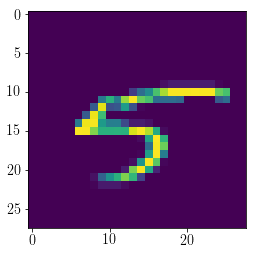

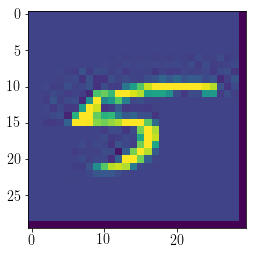

In [853]:
stride = 2
patch_size = (5,5)
index = np.random.choice(labels_train.shape[0])
img, label = X_train[index], labels_train[index]

plt.imshow(img)
print img.shape
# impatches1, img_pad, patch_positions = window_patches_disjoint(img)
impatches, img_pad = window_patches(img,stride,patch_size)

ic_c = linalg.lstsq(ic_comp.T, impatches)
ic_code = ic_c[0].T

nx_patch = pad_shape[0] // patch_size[0]
ny_patch = pad_shape[1] // patch_size[1]
print ('nx ny', nx_patch, ny_patch, ic_code.shape)

image_recon = draw_ic_im(ic_code, ic_comp, mean01, img_pad.shape, stride, patch_size)
plt.figure()
plt.imshow(image_recon)
plt.show()


In [854]:
print impatches1.shape
print impatches.shape

(25, 36)
(25, 169)


In [855]:
def fhrr_vec(D, N):
    if D == 1:
        # pick a random phase
        rphase = 2 * np.pi * np.random.rand(N // 2)
        fhrrv = np.zeros(2 * (N//2))
        fhrrv[:(N//2)] = np.cos(rphase)
        fhrrv[(N//2):] = np.sin(rphase)
        return fhrrv
    
    # pick a random phase
    rphase = 2 * np.pi * np.random.rand(D, N // 2)

    fhrrv = np.zeros((D, 2 * (N//2)))
    fhrrv[:, :(N//2)] = np.cos(rphase)
    fhrrv[:, (N//2):] = np.sin(rphase)
    
    return fhrrv

In [856]:
def cdot(v1, v2):
    return np.dot(np.real(v1), np.real(v2)) + np.dot(np.imag(v1), np.imag(v2))

def cvec(N, D):
    rphase = 2 * np.pi * np.random.rand(N, D)
    return np.cos(rphase) + 1.0j * np.sin(rphase)

def cvecff(N,D,iff=1, iNf=None):
    if iNf is None:
        iNf = N
        
    rphase = 2 * np.pi * np.random.randint(N//iff, size=(N,D)) / iNf
    return np.cos(rphase) + 1.0j * np.sin(rphase)

In [857]:
N=5000
icD = len(which_pcs)

ic_comp_hyperpatch = cvec(N, icD)
X_hyperpos = cvec(N, 1)
Y_hyperpos = cvec(N, 1)

print (ic_comp_hyperpatch.shape, X_hyperpos.shape, Y_hyperpos.shape)

hyper_iccomp = np.dot(ic_comp_hyperpatch, ic_comp)

((5000, 20), (5000, 1), (5000, 1))


In [858]:
cfx=0
a = np.dot(ic_comp_hyperpatch, ic_code[(cfx,), :].T)

In [859]:
hyper_imcode = 0*cvec(N,1)

for y in xrange(0, img_pad.shape[0], stride):
    for x in xrange(0, img_pad.shape[1], stride):
        if y+patch_size[1] <= img_pad.shape[0] and x+patch_size[0] <= img_pad.shape[1]:
            hyper_imcode += X_hyperpos**(x/float(patch_size[0])) * Y_hyperpos ** (y/float(patch_size[1])) * np.dot(ic_comp_hyperpatch, ic_code[cfx:(cfx+1), :].T)
            cfx += 1

In [860]:
def inv_hyper_imcode_disjoint(hypercode, X_hyp, Y_hyp, code_hyp, nx_patch, ny_patch):
    
    ic_code = np.zeros((nx_patch*ny_patch, icD))
    
    for nx in range(nx_patch):
        for ny in range(ny_patch):
            cfx = nx*ny_patch + ny
            deref_hyp = np.conj(X_hyp**nx) * np.conj(Y_hyp**ny) * hypercode
            ic_code[(cfx,), :] = np.real(np.dot(np.conj(code_hyp).T, deref_hyp)).T / N
            #ic_code[cfx, :] = cdot(deref_hyp, code_hyp)
            
    return ic_code

def inv_hyper_imcode(hypercode, X_hyp, Y_hyp, code_hyp, im_shape, stride, patch_size):
    
    #ic_code = np.zeros((nx_patch*ny_patch, icD))
    ic_code = []
    cfx = 0
    for y in xrange(0, im_shape[0], stride):
        for x in xrange(0, im_shape[1], stride):
            if y+patch_size[1] <= im_shape[0] and x+patch_size[0] <= im_shape[1]:
                deref_hyp = np.conj(X_hyp**(x/float(patch_size[0]))) * np.conj(Y_hyp**(y/float(patch_size[1]))) * hypercode
                ic_code.append(np.real(np.dot(np.conj(code_hyp).T, deref_hyp)).T / N)
    return np.array(ic_code)

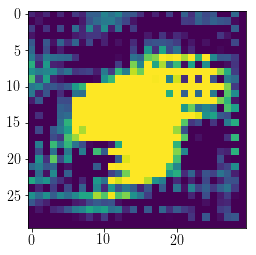

In [868]:
hyper_imcode2 = hyper_imcode * X_hyperpos**(0.25) * Y_hyperpos ** (0)

ic_code = inv_hyper_imcode(hyper_imcode2, X_hyperpos, Y_hyperpos, ic_comp_hyperpatch, img_pad.shape, stride, patch_size)
ic_im = draw_ic_im(ic_code, ic_comp, mean01, img_pad.shape, stride, patch_size)
imshow(ic_im)

In [872]:
from tempfile import NamedTemporaryFile
from matplotlib import animation

from matplotlib.collections import LineCollection, CircleCollection


VIDEO_TAG = """<video controls>
 <source src="data:video/x-m4v;base64,{0}" type="video/mp4">
 Your browser does not support the video tag.
</video>"""

def anim_to_html(anim):
    if not hasattr(anim, '_encoded_video'):
        with NamedTemporaryFile(suffix='.mp4') as f:
            anim.save(f.name, fps=20, extra_args=['-vcodec', 'libx264'])
            video = open(f.name, "rb").read()
        anim._encoded_video = video.encode("base64")
    
    return VIDEO_TAG.format(anim._encoded_video)

from IPython.display import HTML

def display_animation(anim):
    plt.close(anim._fig)
    return HTML(anim_to_html(anim))

In [874]:
fh=figure()
ax=gca()
def animate_tr(i):
    
    x = 0.1*i - 3
    y = 0
    
    hyper_imcode2 = hyper_imcode * X_hyperpos**(x) * Y_hyperpos ** (y)

    ic_code = inv_hyper_imcode(hyper_imcode2, X_hyperpos, Y_hyperpos, ic_comp_hyperpatch, img_pad.shape, stride, patch_size)
    ic_im = draw_ic_im(ic_code, ic_comp, mean01, img_pad.shape, stride, patch_size)
    
    ax.cla()
    ax.imshow(ic_im)

tanim = time.time()
anim = animation.FuncAnimation(fh, animate_tr, frames=60, blit=False)
display_animation(anim)
#fname = 'encoding_resonance_170314-resonance_animation-clear-'  + words[idx] + '-N='  + str(N) + '-M=' + str(M) + '-n' + time.strftime('%y%m%d') + '.mp4'
#print fname
#anim.save(fname, fps=10, extra_args=['-vcodec', 'libx264'])
#print ('\ntotal time: %2.2f ms' % (1000*(time.time() - tanim)))

In[937]
http://128.32.158.211:8888/notebooks/HDlanguageDetection/resonance_hdmsc-decorr-170131.ipynb